In this notebook the angular size of the systematic is evaulated. Therefore, we compute the sqrt ts map of the standard anlysis and compute the 2D Fourier trafo of the first energybin. The obtained angular spectrum is compared with the one computed from a dataset consisting of statistical fluctuations only (asimov dataset). The spectrum of 1000 Poission draws of this asimov dataset are plotted and used for the standard deviation estimation of the anuglar spectrum points. 

In [1]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import astropy
from gammapy.maps import Map
from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from astropy.coordinates import SkyCoord, Angle
from regions import RectangleSkyRegion

import astropy.units as u
import yaml
import sys
sys.path.append('/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters')

import my_dataset_maps_19


spatial binsize =  [0.08] deg


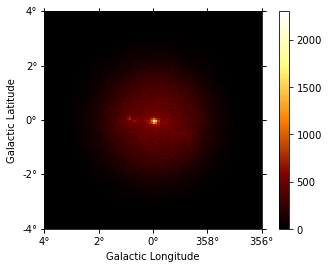

In [2]:
source = 'GC'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'

if source == "Crab":

    # here the dataset with the fine binning is saved
    #dataset = MapDataset.read(f'{path}/{source}/stacked.fits')
    # This is for now the binning of 0.08 deg
    dataset = MapDataset.read(f'{source}/stacked.fits')

    models = Models.read(f"{source}/standard_model.yml")
    
    with open(f"{source}/nui_bgmodel.yml", "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
    bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
    models.append(bkg_model)
    dataset.models = models


    
if source =="GC":
    path_GC ='/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_0.19'
    dataset = MapDataset.read(f'{path_GC}/20220511_dataset002_hess1_muonflagTrue.fits')
    dataset.stack(MapDataset.read(f'{path_GC}/20220511_dataset002_hess2_muonflagTrue.fits'))
    dataset = dataset.downsample(4)



    # Define source model for stacked fit
    from gammapy.modeling.models import (PointSpatialModel, 
                                         ExpCutoffPowerLawSpectralModel,
                                         PowerLawSpectralModel,
                                         GaussianSpatialModel,TemplateSpatialModel,
                                        PowerLawNormSpectralModel)
    spatial_model_center = PointSpatialModel(lon_0=359.9439608*u.deg, lat_0=-0.0418969*u.deg, frame='galactic') 
    spectral_model_center = ExpCutoffPowerLawSpectralModel(index=2.14, amplitude="2.55e-12 cm-2 s-1 TeV-1", reference="1 TeV", lambda_='0.093 TeV-1')
    source_model_center = SkyModel(spatial_model=spatial_model_center, spectral_model=spectral_model_center, name="src")

    spatial_model_g09 = PointSpatialModel(lon_0=0.8717549*u.deg, lat_0=0.0767488*u.deg, frame='galactic')
    spectral_model_g09 = PowerLawSpectralModel(index=2.4, amplitude="0.838e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
    source_model_g09 = SkyModel(spatial_model=spatial_model_g09, spectral_model=spectral_model_g09, name="g09")

    spatial_model_1745 = GaussianSpatialModel(lon_0=358.6435538*u.deg, lat_0=-0.5617789*u.deg, sigma=0.179*u.deg, frame='galactic')
    spectral_model_1745 = PowerLawSpectralModel(index=2.57, amplitude="1.73e-12 cm-2 s-1 TeV-1", reference="1 TeV") # 
    source_model_1745 = SkyModel(spatial_model=spatial_model_1745, spectral_model=spectral_model_1745, name="1745")

    spatial_model_1746 = PointSpatialModel(lon_0=0.1384563*u.deg, lat_0=-0.1112664*u.deg, frame='galactic')
    spectral_model_1746 = PowerLawSpectralModel(index=2.17, amplitude="0.18e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
    source_model_1746 = SkyModel(spatial_model=spatial_model_1746, spectral_model=spectral_model_1746, name="1746")

    spatial_model_1746308 = GaussianSpatialModel(lon_0=358.4479799*u.deg, lat_0=-1.1140008*u.deg, sigma=0.162*u.deg, frame='galactic')
    spectral_model_1746308 = PowerLawSpectralModel(index=3.27, amplitude="0.70e-12 cm-2 s-1 TeV-1", reference="1 TeV") #
    source_model_1746308 = SkyModel(spatial_model=spatial_model_1746308, spectral_model=spectral_model_1746308, name="1746308")

    spatial_model_1741 = PointSpatialModel(lon_0=358.2753545*u.deg, lat_0=0.0515537*u.deg, frame='galactic')
    spectral_model_1741 = PowerLawSpectralModel(index=2.30, amplitude="0.21e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
    source_model_1741 = SkyModel(spatial_model=spatial_model_1741, spectral_model=spectral_model_1741, name="1741")

    diffuse_gal = Map.read("/home/saturn/caph/mppi043h/diffusiontemplate/cont_pcut_v3.fits")
    diffuse_gal.geom.axes[0].name= 'energy_true'
    template_diffuse = TemplateSpatialModel(
        diffuse_gal, normalize=False
    )
    diffuse_model = SkyModel(
        spectral_model=PowerLawNormSpectralModel(),
        spatial_model=template_diffuse,
        name="Diffuse Emission",)
    
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters['tilt'].frozen  = False

    models = Models([source_model_center, source_model_g09, source_model_1745, source_model_1746, 
                     source_model_1746308, source_model_1741, diffuse_model, bkg_model ])
    
    
    j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')

    skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)
    geom_2d = dataset.geoms['geom'].drop('energy')
    dataset.mask_safe.data[:] &= Map.from_geom(geom_2d, 
                                                        data=geom_2d.region_mask([skyregion_1745], 
                                                                                          inside=False).data).data
    
    dataset.models = models
    
dataset.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset.geoms["geom"].width[1] / dataset.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)





In [3]:
fit_standarad = Fit(store_trace=False)
result_standarad = fit_standarad.run([dataset])

Position <SkyCoord (Galactic): (l, b) in deg
    (88.08893066, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (88.08893066, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (271.79899094, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (271.79899094, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (8.75845779, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (8.75845779, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (351.12946381, -0.0418969)> is outside valid IRF map range, using nearest IRF defined within
Position <Sk

import dataset and best fit model

In [ ]:
print(
    "spatial binsize = ",
    dataset.geoms["geom"].width[1]
    / dataset.geoms["geom"].data_shape[1],
)


computation of the sqrt ts map

In [ ]:
def get_residual(estart, eend, dataset_1 , smooth):
    res_1 = dataset_1.slice_by_energy(estart*u.TeV, eend*u.TeV).residuals( 'diff/sqrt(model)')
    return res_1.smooth(smooth*u.deg).sum_over_axes()
def get_residual3(estart, eend, dataset_1 , smooth):
    dat_1 = dataset_1
    res_1 = dat_1.counts - dat_1.npred()
    res_1.data /= np.sqrt(dat_1.npred().data)
    return res_1.smooth(smooth*u.deg).slice_by_idx(dict(energy = slice(estart, eend))).sum_over_axes()
def get_residual2(estart,eend, dataset_1, smooth):
    res_standard = (
        dataset_1.residuals("diff/sqrt(model)")
        .slice_by_idx(dict(energy=slice(estart,eend)))
        .smooth(smooth * u.deg)
            )
    return res_standard.sum_over_axes()

In [ ]:
start, end =6,24
cutout = 6 *u.deg
N= 100
geom = dataset.geoms['geom']
result = get_residual2(start, end , dataset ,0.).cutout(geom.center_skydir, cutout)#.smooth(0.1*u.deg)
vmax =4
result.plot(add_cbar = 1, cmap = 'coolwarm', vmax = vmax, vmin = -vmax);

1000 Poission drawns of the Asimov dataset.

In [ ]:
e_start, e_end = dataset.geoms['geom'].axes[0].edges[start],dataset.geoms['geom'].axes[0].edges[end]
observed  = result#.slice_by_idx(dict(energy=slice(start, end)))


res_stat_N = []
datasets_stat = dataset.copy()
datasets_stat.counts =  Map.from_geom(geom = datasets_stat.geoms['geom'])
for n in range(N):
    rng = np.random.RandomState()
    datasets_stat.counts.data = rng.poisson(datasets_stat.npred().data)
    
    result = get_residual2(start, end , datasets_stat ,0.).cutout(geom.center_skydir,cutout)
    res_stat_N.append(result)#["sqrt_ts"].slice_by_idx(dict(energy=slice(start, end))))

In [ ]:
if source == "Crab":
    datasetN_path2 = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/output/'
    datasetN_path2 += '2022-03-22/'
    datasetN_path2 += 'Crab_max_sysamplitude_48.7_downsampling_factor_25_statthreshold1_estart_0.3_eend_120.0/'

    path = datasetN_path2
    dataset_N_10 = my_dataset_maps_19.MapDatasetNuisance.read(path+ 'nui_dataset.fits')
    with open(path+ 'nui_par.yml', "r") as ymlfile:
        nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
    dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
    with open(path+ 'nui_model.yml', "r") as ymlfile:
        best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
    with open(path+ 'nui_bgmodel.yml', "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    models = Models.from_dict(best_fit_model )
    models.append(bkg_model)
    dataset_N_10.models =models
    print(dataset_N_10.models)

    emask_map = dataset_N_10.background.geom.energy_mask(
                    energy_min = 0.3*u.TeV,  energy_max =  120*u.TeV)
    dataset_N_10.mask_fit = emask_map
    dataset_N_10.mask_safe = emask_map

    result_N = get_residual2(start, end , dataset_N_10 ,0.).cutout(geom.center_skydir, cutout)
    result_N.plot()

Function used to compute the fourier tranfos of the observed residual and the statistical datasets

In [ ]:
half_width_fov = cutout.value /2

def plot_fourier (res_dataset_v0s, stats_res = None, labels_datasets = None):
    #image = mpimg.imread("clouds.png")
    for i,res_dataset_v0 in enumerate(res_dataset_v0s):
        image =res_dataset_v0[0].data
        npix = image.shape[1]
        kfreq = np.fft.fftfreq(npix) * npix
        kfreq2D = np.meshgrid(kfreq, kfreq)
        knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
        knrm = knrm.flatten()
        kbins = np.arange(0.5, npix//2+1, 1.)
        kvals = 0.5 * (kbins[1:] + kbins[:-1])
        print('knrm', len(knrm))
        Abinss = []
        if labels_datasets[i] == 'Standard':
            color = default_colors[1]
        else:
            color = default_colors[1:][i]
        for d in res_dataset_v0:
            image =d.data
            image = np.nan_to_num(image)
            fourier_image = np.fft.fftn(image)
            fourier_amplitudes = np.abs(fourier_image)**2

            fourier_amplitudes = fourier_amplitudes.flatten()
            Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                                 statistic = "mean",
                                                 bins = kbins)
            Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
            plt.loglog(kvals, Abins, '-',#alpha = 0.001963,
                       alpha = 0.02, color = color, label = '')
            Abinss.append(Abins)
        label = ''
        if labels_datasets is not None:
            label += labels_datasets[i]
        plt.errorbar(x = kvals,y =  np.mean(Abinss, axis = 0),
                     yerr = np.std(Abinss,axis = 0), fmt= 'x-', 
                     alpha = 0.9,  label = label ,
                    color = color)
    if stats_res is not None:
        Abinss_stat = []
        for stats_re in stats_res:
            image =stats_re.data
            image = np.nan_to_num(image)

            fourier_image = np.fft.fftn(image)
            fourier_amplitudes = np.abs(fourier_image)**2
            fourier_amplitudes = fourier_amplitudes.flatten()
            Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                                 statistic = "mean",
                                                 bins = kbins)
            Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
            plt.loglog(kvals, Abins, '-',alpha = 5/N, color = 'black', label = '')
            Abinss_stat.append(Abins)
        #plt.loglog(kvals, np.mean(Abinss, axis = 0), 'x-',alpha = 0.9, color = 'black' ,label = 'Stat')
        plt.errorbar(x = kvals,y =  np.mean(Abinss_stat, axis = 0),
                     yerr = np.std(Abinss_stat,axis = 0),
                     fmt = '-',alpha = 0.9, color = 'black' ,label = 'Stat')


    ax = plt.gca() ;    fig = plt.gcf() ;    ax2 = ax.twiny()
    labels = ['1', '2', '5', '10', '20','25']

    def tick_function(X):
        return ["%.2f$^\circ$" % (half_width_fov/x) for x in X]
    ax2.set_xlim(ax.get_xlim())
    new_tick_locations = [1.,2.,5.,10.,20., 25.,]
    ax2.set_xticks(new_tick_locations) ;    ax2.set_xticklabels(tick_function(new_tick_locations))
    yy = ax.get_ylim()
    for i, data in enumerate(new_tick_locations):
        if i >-1:
            ax2.vlines(50/float(labels[::-1][i]), yy[0], yy[1], 
                       color = default_colors[:6][::-1][i],
                      alpha = 0.5)
    ax2.set_xscale('log') ;   ax2.set_xticks(new_tick_locations) ;ax2.set_xticklabels(tick_function(new_tick_locations))
    ax.set_xlabel("$k$") ;    ax2.set_xlabel("Angular Scale") ;    ax2.set_ylabel("Fourier Amplitude")
    ax.set_ylabel("$P(k)$") ;    plt.tight_layout();    plt.grid() ; 
    ax.legend(title= 'Stat+sys', loc = 'lower right')
    #plt.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")
    
    
    ## compute the size of the sys (i.e. look where the observed fourier is not within
    ## the 2simga of the mean
    
    i =0 
    stat_mean, stat_std = np.mean(Abinss_stat, axis = 0), np.std(Abinss_stat, axis = 0)
    observed = np.mean(Abinss, axis = 0)
    while ( ( (stat_mean[i]+ 2*stat_std[i]) < observed[i]) or ((stat_mean[i]- 2*stat_std[i]) > observed[i])):
        #print(((stat_mean[i]- 2*stat_std[i]) > observed[i]))
        i +=1
    size = half_width_fov/(i+1)
    print("Estimated angular size of the Sys:",size , " deg")

    return fig ,  size

In [ ]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Resulting plot

In [ ]:
fig, size  = plot_fourier ([[observed]], res_stat_N, labels_datasets=['Observed'])
ax = plt.gca() ;ax.set_title("{} at [{:.1}:{:.1}] TeV".format(source, e_start, e_end));
fig = plt.gcf()
name = f'{source}'+'/plots/Angular_spectrum'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')

outputpath = f'{source}/angular_size.txt'
print(f"saving in {outputpath} ...")
with open(outputpath, 'w') as f:
    f.write(str(size))

Interpretation:
- Diffraction pattern due to the edges visible in both the observed spectrum and stat 
- Deviation up to an angular scale of approx. 0.8 deg
- For this pariticular dataset the bisize of the nuisance parameters is recommendend in the same size. (downsampling : 10)

In [ ]:
fig  = plot_fourier ([[observed],[result_N]], res_stat_N, labels_datasets=['Observed', "Nuisance 0.8deg"])
ax = plt.gca() ;ax.set_title("{} at [{:.1}:{:.1}] TeV".format(source, e_start, e_end));
fig = plt.gcf()
name = f'{source}'+'/plots/Angular_spectrum_N'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')


